In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [3]:
ds = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates = ['date'])
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
def prepdata(df):
    for col_name, col_data in df.items():
        # Check if the column is of datetime type
        if pd.api.types.is_datetime64_any_dtype(col_data):
            # Extract useful datetime features
            df['year'] = col_data.dt.year
            df['month'] = col_data.dt.month
            df['day'] = col_data.dt.day
            df['dayofweek'] = col_data.dt.dayofweek
            df['is_weekend'] = (col_data.dt.weekday >= 5).astype(int)
            df['is_start_of_week'] = (col_data.dt.weekday == 0).astype(int)
            df['is_start_of_month'] = (col_data.dt.day == 1).astype(int)
    
    return df

In [5]:
def columnstodrop(df,columnsdp):
    df = df.drop(columns=columnsdp)
    return df

In [6]:
def encoder(df,col_name):
    label_encoder = LabelEncoder()
    df[col_name + 'encoded'] = label_encoder.fit_transform(df[col_name])
    df = df.drop(columns=col_name)
    return df

In [7]:
ds = prepdata(ds)
ds

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,is_weekend,is_start_of_week,is_start_of_month
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,1,0,0,1
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,1,0,0,1
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,1,0,0,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,1,0,0,1
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,1,0,0,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,1,0,0,0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,1,0,0,0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,1,0,0,0


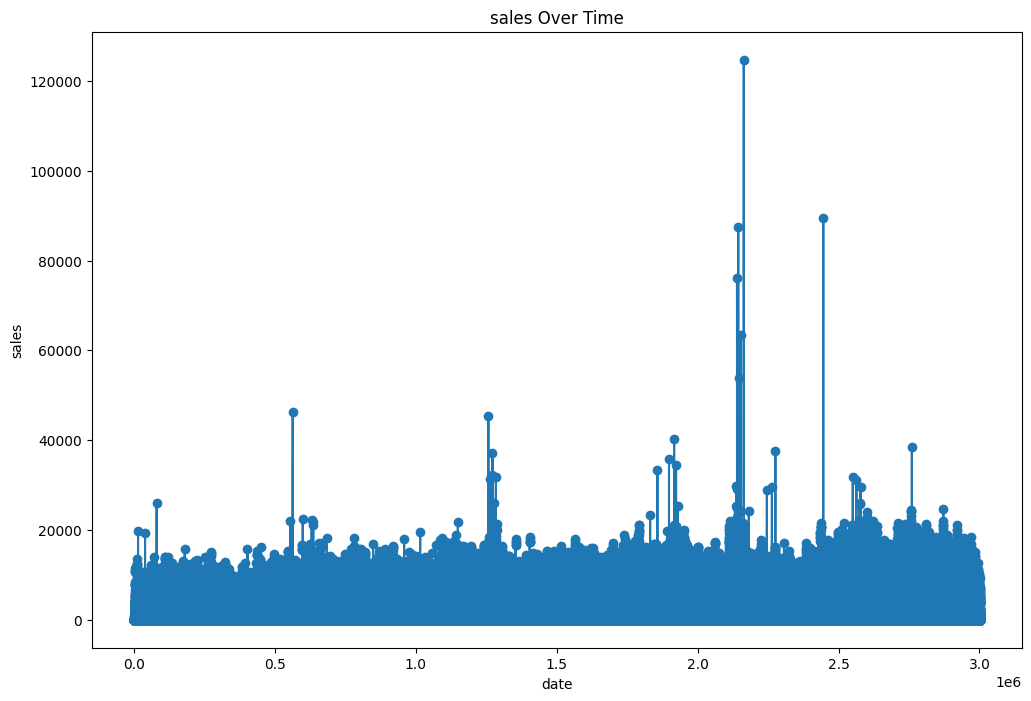

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot Temperature
plt.plot(ds.index, ds['sales'], marker='o')
plt.title('sales Over Time')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()



In [9]:
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv",parse_dates = ['date'])
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv",parse_dates = ['date'])
holidays=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv",parse_dates = ['date'])

In [10]:
print(oil.info(),stores.info(),transactions.info(),holidays.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date

In [11]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()
oil['dcoilwtico']= oil['dcoilwtico'].bfill()

In [12]:
ds = ds.merge(stores, how='left', on='store_nbr')
ds = ds.merge(oil, how='left', on='date')
ds = ds.merge(holidays, how='left', on='date')

In [13]:
ds.isnull().sum()

id                         0
date                       0
store_nbr                  0
family                     0
sales                      0
onpromotion                0
year                       0
month                      0
day                        0
dayofweek                  0
is_weekend                 0
is_start_of_week           0
is_start_of_month          0
city                       0
state                      0
type_x                     0
cluster                    0
dcoilwtico            878526
type_y               2551824
locale               2551824
locale_name          2551824
description          2551824
transferred          2551824
dtype: int64

In [14]:
ds

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,1,...,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,1,...,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,1,...,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,1,...,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,1,...,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,1,...,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,1,...,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,1,...,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,1,...,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [15]:
columns_to_drop =['type_x','locale','locale_name','description','transferred']
ds = columnstodrop(ds,columns_to_drop)
ds['dcoilwtico'] = ds['dcoilwtico'].fillna(ds['dcoilwtico'].median())
ds = pd.get_dummies(ds, columns=['type_y'], drop_first=True)
ds

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,is_start_of_month,city,state,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,1,...,1,Quito,Pichincha,13,93.14,False,False,True,False,False
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,1,...,1,Quito,Pichincha,13,93.14,False,False,True,False,False
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,1,...,1,Quito,Pichincha,13,93.14,False,False,True,False,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,1,...,1,Quito,Pichincha,13,93.14,False,False,True,False,False
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,1,...,1,Quito,Pichincha,13,93.14,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,1,...,0,Quito,Pichincha,6,47.57,False,False,True,False,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,1,...,0,Quito,Pichincha,6,47.57,False,False,True,False,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,1,...,0,Quito,Pichincha,6,47.57,False,False,True,False,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,1,...,0,Quito,Pichincha,6,47.57,False,False,True,False,False


In [16]:
dsample = ds.sample(frac=0.008, random_state=42)
dsample

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,is_start_of_month,city,state,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day
668753,659843,2014-01-07,23,DAIRY,471.000,0,2014,1,7,1,...,0,Ambato,Tungurahua,9,93.31,False,False,False,False,False
1267004,1250966,2014-12-05,1,BEAUTY,1.000,0,2014,12,5,4,...,0,Quito,Pichincha,13,65.89,False,False,False,False,False
997442,981404,2014-07-06,45,HOME APPLIANCES,0.000,0,2014,7,6,6,...,0,Quito,Pichincha,11,53.41,False,False,False,False,False
873596,864686,2014-05-02,20,LAWN AND GARDEN,0.000,0,2014,5,2,4,...,0,Quito,Pichincha,6,100.09,False,False,False,False,False
756145,747235,2014-02-25,25,HOME AND KITCHEN II,0.000,0,2014,2,25,1,...,0,Salinas,Santa Elena,1,102.20,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586286,1566684,2015-06-01,18,DELI,290.117,1,2015,6,1,0,...,1,Quito,Pichincha,16,60.24,False,False,False,False,False
2107298,2080568,2016-03-16,36,HOME APPLIANCES,0.000,0,2016,3,16,2,...,0,Libertad,Guayas,10,38.43,False,False,False,False,False
96544,96544,2013-02-24,18,LADIESWEAR,0.000,0,2013,2,24,6,...,0,Quito,Pichincha,16,53.41,False,False,False,False,False
2749940,2703608,2017-03-02,18,HOME APPLIANCES,0.000,0,2017,3,2,3,...,0,Quito,Pichincha,16,52.63,False,False,True,False,False


/tmp/ipykernel_18/611021862.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dsample['sales'], shade=True, color='green')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


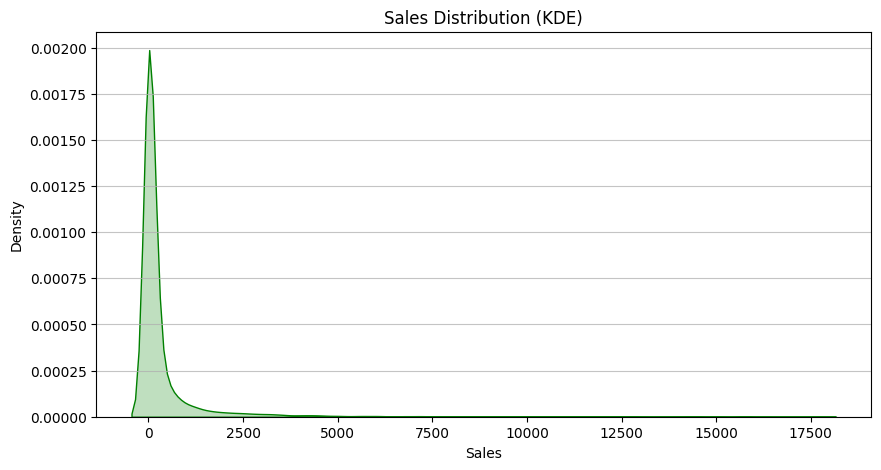

In [17]:
#sales destribution
plt.figure(figsize=(10, 5))
sns.kdeplot(dsample['sales'], shade=True, color='green')
plt.title('Sales Distribution (KDE)')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:


# Convert boolean columns to integer
boolean_columns = ['type_y_Bridge','type_y_Event','type_y_Holiday','type_y_Transfer','type_y_Work Day']
for col in boolean_columns:
    dsample[col] = dsample[col].astype(int)

In [19]:
# Apply Label Encoding 
dsample= encoder(dsample,'state')
dsample= encoder(dsample,'family')
dsample= encoder(dsample,'city')
dsample

,id,date,store_nbr,sales,onpromotion,year,month,day,dayofweek,is_weekend,...,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day,stateencoded,familyencoded,cityencoded
668753,659843,2014-01-07,23,471.000,0,2014,1,7,1,0,...,9,93.31,0,0,0,0,0,15,8,0
1267004,1250966,2014-12-05,1,1.000,0,2014,12,5,4,0,...,13,65.89,0,0,0,0,0,12,2,18
997442,981404,2014-07-06,45,0.000,0,2014,7,6,6,1,...,11,53.41,0,0,0,0,0,12,17,18
873596,864686,2014-05-02,20,0.000,0,2014,5,2,4,0,...,6,100.09,0,0,0,0,0,12,20,18
756145,747235,2014-02-25,25,0.000,0,2014,2,25,1,0,...,1,102.20,0,0,0,0,0,13,16,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586286,1566684,2015-06-01,18,290.117,1,2015,6,1,0,0,...,16,60.24,0,0,0,0,0,12,9,18
2107298,2080568,2016-03-16,36,0.000,0,2016,3,16,2,0,...,10,38.43,0,0,0,0,0,6,17,11
96544,96544,2013-02-24,18,0.000,0,2013,2,24,6,1,...,16,53.41,0,0,0,0,0,12,19,18
2749940,2703608,2017-03-02,18,0.000,0,2017,3,2,3,0,...,16,52.63,0,0,1,0,0,12,17,18


In [20]:
x=dsample.drop(axis=1,columns=["id","date","sales"])
y=dsample["sales"]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3)
x

,store_nbr,onpromotion,year,month,day,dayofweek,is_weekend,is_start_of_week,is_start_of_month,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day,stateencoded,familyencoded,cityencoded
668753,23,0,2014,1,7,1,0,0,0,9,93.31,0,0,0,0,0,15,8,0
1267004,1,0,2014,12,5,4,0,0,0,13,65.89,0,0,0,0,0,12,2,18
997442,45,0,2014,7,6,6,1,0,0,11,53.41,0,0,0,0,0,12,17,18
873596,20,0,2014,5,2,4,0,0,0,6,100.09,0,0,0,0,0,12,20,18
756145,25,0,2014,2,25,1,0,0,0,1,102.20,0,0,0,0,0,13,16,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586286,18,1,2015,6,1,0,0,1,1,16,60.24,0,0,0,0,0,12,9,18
2107298,36,0,2016,3,16,2,0,0,0,10,38.43,0,0,0,0,0,6,17,11
96544,18,0,2013,2,24,6,1,0,0,16,53.41,0,0,0,0,0,12,19,18
2749940,18,0,2017,3,2,3,0,0,0,16,52.63,0,0,1,0,0,12,17,18


In [21]:
classifiers={
    "RandomForestRegressor":RandomForestRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "SGDRegressor":SGDRegressor(),
    "MLPRegressor":MLPRegressor()
}
Results={
    "Classifier":[],
    "r2 Score":[]
}

for classifier_name,classifier in classifiers.items():
    classifier.fit(xtrain,ytrain)
    prediction=classifier.predict(xtest)
    r2=r2_score(ytest,prediction)
    Results["Classifier"].append(classifier_name)
    Results["r2 Score"].append(r2)
    
results=pd.DataFrame(Results)
results

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,r2 Score
0,RandomForestRegressor,8.108031e-01
1,AdaBoostRegressor,-8.418749e-01
2,SGDRegressor,-2.155347e+23
3,MLPRegressor,2.673655e-01


In [22]:
params={
    "n_estimators":[200,225,250,275],
    "max_depth":[None,3,4,5],
    "min_samples_split":[2,3],
    "min_samples_leaf":[1,2,3]
}
forest=RandomForestRegressor()
Search=GridSearchCV(estimator=forest,param_grid=params,scoring="r2")
Search.fit(xtrain,ytrain)
best_params = Search.best_params_
print("Best Parameters found:")
print(Search.best_params_)
print("Best R2 Score:")
print(Search.best_score_)
y_pred = Search.best_estimator_.predict(xtest)
Final_r2 = r2_score(ytest, y_pred)
print("Final R2 = ",Final_r2)

Best Parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 225}
Best R2 Score:
0.7958324504058487
Final R2 =  0.8149993027998459


In [23]:
# Convert boolean columns to integer
for col in boolean_columns:
    ds[col] = ds[col].astype(int)
ds= encoder(ds,'state')
ds= encoder(ds,'family')
ds= encoder(ds,'city')
x1=ds.drop(axis=1,columns=["id","date","sales"])
y1=ds["sales"]
xtrainf,xtestf,ytrainf,ytestf=train_test_split(x1,y1,test_size=0.3)

In [24]:
final_forest=RandomForestRegressor(**best_params)
final_forest.fit(xtrainf,ytrainf)
prediction=final_forest.predict(xtestf)
Final_r2_score=r2_score(ytestf,prediction)
print("Final R2 score =",Final_r2_score)

Final R2 score = 0.9406469004416755


In [25]:
teste = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',parse_dates = ['date'])

In [26]:
teste= prepdata(teste)
teste

,id,date,store_nbr,family,onpromotion,year,month,day,dayofweek,is_weekend,is_start_of_week,is_start_of_month
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,0,0,0
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,0,0,0
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,0,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,0,0,0
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,2017,8,31,3,0,0,0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,2017,8,31,3,0,0,0
28509,3029397,2017-08-31,9,PRODUCE,1,2017,8,31,3,0,0,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,31,3,0,0,0


In [27]:
teste = teste.merge(stores, how='left', on='store_nbr')
teste = teste.merge(oil, how='left', on='date')
teste = teste.merge(holidays, how='left', on='date')

In [28]:

teste = columnstodrop(teste,columns_to_drop)
teste['dcoilwtico'] = teste['dcoilwtico'].fillna(teste['dcoilwtico'].median())
teste['type_y_Bridge'] = 0
teste['type_y_Event'] = 0
teste = pd.get_dummies(teste, columns=['type_y']) # sem drop_firts, so tem uma varivel
teste['type_y_Transfer']= 0
teste['type_y_Work Day']= 0
teste


,id,date,store_nbr,family,onpromotion,year,month,day,dayofweek,is_weekend,...,is_start_of_month,city,state,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,False,0,0
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,False,0,0
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,False,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,False,0,0
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,False,0,0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,False,0,0
28509,3029397,2017-08-31,9,PRODUCE,1,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,False,0,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,False,0,0


In [29]:
# Convert boolean columns to integer
teste['type_y_Holiday'] = teste['type_y_Holiday'].astype(int)
teste
    

,id,date,store_nbr,family,onpromotion,year,month,day,dayofweek,is_weekend,...,is_start_of_month,city,state,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,0,0,0
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,0,0,0
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,0,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,0,0,0
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,0,...,0,Quito,Pichincha,13,46.80,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,0,0,0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,0,0,0
28509,3029397,2017-08-31,9,PRODUCE,1,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,0,0,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,31,3,0,...,0,Quito,Pichincha,6,47.26,0,0,0,0,0


In [30]:
# Apply Label Encoding to 'state' and 'city'
teste= encoder(teste,'state')
teste= encoder(teste,'family')
teste= encoder(teste,'city')
teste 

,id,date,store_nbr,onpromotion,year,month,day,dayofweek,is_weekend,is_start_of_week,...,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day,stateencoded,familyencoded,cityencoded
0,3000888,2017-08-16,1,0,2017,8,16,2,0,0,...,13,46.80,0,0,0,0,0,12,0,18
1,3000889,2017-08-16,1,0,2017,8,16,2,0,0,...,13,46.80,0,0,0,0,0,12,1,18
2,3000890,2017-08-16,1,2,2017,8,16,2,0,0,...,13,46.80,0,0,0,0,0,12,2,18
3,3000891,2017-08-16,1,20,2017,8,16,2,0,0,...,13,46.80,0,0,0,0,0,12,3,18
4,3000892,2017-08-16,1,0,2017,8,16,2,0,0,...,13,46.80,0,0,0,0,0,12,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,1,2017,8,31,3,0,0,...,6,47.26,0,0,0,0,0,12,28,18
28508,3029396,2017-08-31,9,0,2017,8,31,3,0,0,...,6,47.26,0,0,0,0,0,12,29,18
28509,3029397,2017-08-31,9,1,2017,8,31,3,0,0,...,6,47.26,0,0,0,0,0,12,30,18
28510,3029398,2017-08-31,9,9,2017,8,31,3,0,0,...,6,47.26,0,0,0,0,0,12,31,18


In [31]:
xteste=teste.drop(axis=1,columns=["id","date"])
xteste

,store_nbr,onpromotion,year,month,day,dayofweek,is_weekend,is_start_of_week,is_start_of_month,cluster,dcoilwtico,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day,stateencoded,familyencoded,cityencoded
0,1,0,2017,8,16,2,0,0,0,13,46.80,0,0,0,0,0,12,0,18
1,1,0,2017,8,16,2,0,0,0,13,46.80,0,0,0,0,0,12,1,18
2,1,2,2017,8,16,2,0,0,0,13,46.80,0,0,0,0,0,12,2,18
3,1,20,2017,8,16,2,0,0,0,13,46.80,0,0,0,0,0,12,3,18
4,1,0,2017,8,16,2,0,0,0,13,46.80,0,0,0,0,0,12,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,9,1,2017,8,31,3,0,0,0,6,47.26,0,0,0,0,0,12,28,18
28508,9,0,2017,8,31,3,0,0,0,6,47.26,0,0,0,0,0,12,29,18
28509,9,1,2017,8,31,3,0,0,0,6,47.26,0,0,0,0,0,12,30,18
28510,9,9,2017,8,31,3,0,0,0,6,47.26,0,0,0,0,0,12,31,18


In [32]:
Final_predictions=final_forest.predict(xteste)
output = pd.DataFrame({'id': teste['id'], 'sales': Final_predictions})
output.to_csv('Archivo_de_predicciones.csv', index=False)